### Objective Function

Given:
- $ \mathbf{x}' \in \mathbb{R}^d $: Target variable (Counterfactual Explanation).
- $ \mathbf{x} \in \mathbb{R}^d $: Conditional variable (Data Point).
- $ p_\theta(\mathbf{x}' | \mathbf{x}) $: Conditional density modeled by the flow.

The optimization objective with an $ \ell_2 $-penalty is:

$$
\mathcal{L}(\theta) = -  \log p_\theta(\mathbf{x} | \mathbf{x}') + \lambda \|\mathbf{x} - \mathbf{x}'\|_2^2,
$$

where:
- $ \log p_\theta(\mathbf{x}' | \mathbf{x}) = \log p_\theta(\mathbf{z}) - \log \left| \det \frac{\partial f_\theta(\mathbf{x}', \mathbf{x})}{\partial \mathbf{x}} \right| $,
- $ \mathbf{z} = f_\theta(\mathbf{x}', \mathbf{x}) $,
- $ \lambda \geq 0 $: Hyperparameter for $ \ell_2 $-penalty.

Expanded:
$$
\mathcal{L}(\theta) = - \log p_\theta(f_\theta(\mathbf{x}, \mathbf{x}')) - \log \left| \det \frac{\partial f_\theta(\mathbf{x}, \mathbf{x}')}{\partial \mathbf{x}} \right| + \lambda \|\mathbf{x} - \mathbf{x}'\|_2^2.
$$

### Optimization Problem

$$
\theta^* = \arg\min_\theta \mathcal{L}(\theta).
$$

### Components
1. **Conditional Log-Likelihood**:
   $$
   -\log p_\theta(\mathbf{x} | \mathbf{x}').
   $$
2. **Regularization**: 
   $$
   \lambda \|\mathbf{x} - \mathbf{x}'\|_2^2.
   $$
3. **Trade-off**: Controlled by $ \lambda $.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from matplotlib import cm
from torch.utils.data import DataLoader, Dataset


from counterfactuals.datasets.moons import MoonsDataset
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import (
    LogisticRegression,
    MultilayerPerceptron,
)
from counterfactuals.cf_methods.gence.gence import GenCE

/Users/ofurman/Private/counterfactuals/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
class PairDataset(Dataset):
    def __init__(self, class_zero, class_one, length=None):
        """
        Initialize with two arrays, one for each class.
        """
        self.length = length
        self.class_zero = torch.tensor(class_zero)
        self.class_one = torch.tensor(class_one)
        self.size_zero = class_zero.shape[0]
        self.size_one = class_one.shape[0]

        # Calculate l2 distances between all pairs of class zero and class one
        dist = torch.cdist(self.class_zero, self.class_one)
        self.distances = 1 / (1 + dist)  # use distance as weight in inverse manner

        # Normalize the weights so they sum to 1
        self.distances = self.distances / self.distances.sum(dim=1, keepdim=True)

    def __len__(self):
        # The total combinations are len(class_zero) * len(class_one)
        if self.length is not None:
            return self.length
        return self.size_zero * self.size_one

    def __getitem__(self, idx):
        # randomly select one from each class
        # sample the other with weights inversely proportional to distance (1/1+d)

        i = torch.randint(0, self.size_zero, (1,)).item()
        j = np.random.choice(self.size_one, p=self.distances[i].numpy())

        x = self.class_zero[i]
        y = self.class_one[j]

        if torch.rand(1) > 0.5:
            x, y = y, x

        return torch.tensor(x, dtype=torch.float32), torch.tensor(
            y, dtype=torch.float32
        )

In [4]:
dataset = MoonsDataset(file_path="../data/moons.csv")

In [18]:
flow_train_dataloader = dataset.train_dataloader(
    batch_size=128, shuffle=True, noise_lvl=0.03
)
flow_test_dataloader = dataset.test_dataloader(batch_size=128, shuffle=False)
flow = MaskedAutoregressiveFlow(
    features=dataset.X_test.shape[1],
    hidden_features=16,
    num_blocks_per_layer=4,
    num_layers=8,
    context_features=1,
)
flow.fit(flow_train_dataloader, flow_test_dataloader, num_epochs=1000, patience=50)

Epoch 195, Train: -1.2607, test: -1.2745, patience: 50:  20%|█▉        | 195/1000 [00:11<00:46, 17.40it/s]
/Users/ofurman/Private/counterfactuals/counterfactuals/generative_models/maf.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue 

In [5]:
dataset = MoonsDataset(file_path="../data/moons.csv")
disc_model = LogisticRegression(input_size=2, target_size=1)
train_dataloader = dataset.train_dataloader(batch_size=256, shuffle=True, noise_lvl=0.0)
test_dataloader = dataset.test_dataloader(batch_size=256, shuffle=False)
disc_model.fit(train_dataloader, test_dataloader, epochs=10000, patience=300, lr=1e-3)

Epoch 3850, Train: 0.2747, test: 0.2829, patience: 300:  38%|███▊      | 3850/10000 [00:13<00:21, 283.01it/s]
/Users/ofurman/Private/counterfactuals/counterfactuals/discriminative_models/logistic_regression.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file.

In [6]:
dataset = MoonsDataset(file_path="../data/moons.csv")
disc_model = MultilayerPerceptron(
    input_size=2, hidden_layer_sizes=[256, 256], target_size=1, dropout=0.2
)
train_dataloader = dataset.train_dataloader(batch_size=64, shuffle=True, noise_lvl=0.0)
test_dataloader = dataset.test_dataloader(batch_size=64, shuffle=False)
disc_model.fit(train_dataloader, test_dataloader, epochs=10000, patience=300, lr=1e-3)
# disc_model.load("../models/MoonsDataset/disc_model_MultilayerPerceptron.pt")

disc_model.eval()
dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/ofurman/Private/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

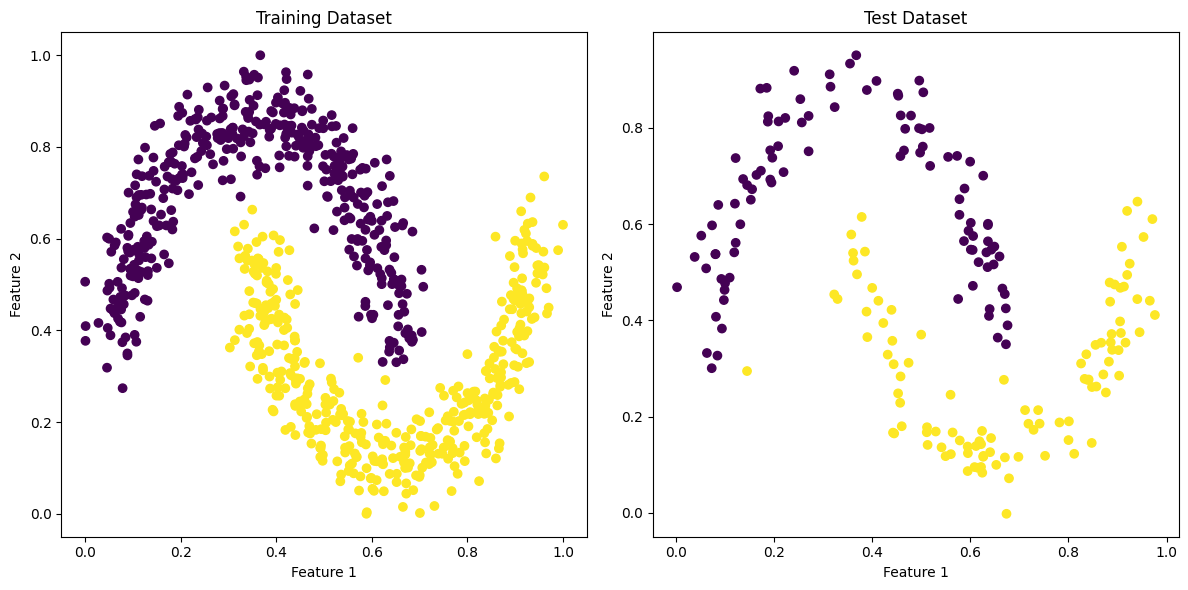

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot training dataset
axes[0].scatter(dataset.X_train[:, 0], dataset.X_train[:, 1], c=dataset.y_train, cmap='viridis', marker='o')
axes[0].set_title('Training Dataset')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Plot test dataset
axes[1].scatter(dataset.X_test[:, 0], dataset.X_test[:, 1], c=dataset.y_test, cmap='viridis', marker='o')
axes[1].set_title('Test Dataset')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [11]:
class_zero = dataset.X_train[dataset.y_train == 0]
class_one = dataset.X_train[dataset.y_train == 1]

pair_dataset_train = PairDataset(class_zero, class_one, length=5000)


def collate_fn(batch):
    X, y = zip(*batch)
    X = torch.stack(X)
    y = torch.stack(y)
    noise = torch.randn_like(X) * 0.03
    noise = torch.randn_like(y) * 0.03
    X = X + noise
    y = y + noise
    return X, y


train_dataloader = DataLoader(
    pair_dataset_train, batch_size=256, shuffle=True, collate_fn=collate_fn
)

/var/folders/57/flzvlrr53ybd92618zbxl4jm0000gn/T/ipykernel_15268/3949406364.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


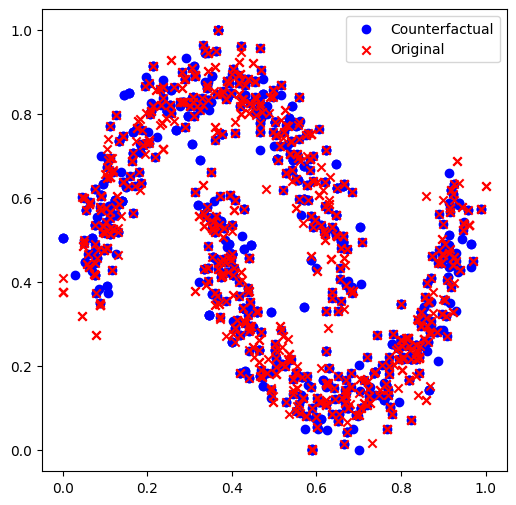

In [12]:
x_cfs, x_origs = [], []
for i in range(1000):
    x_cf, x_orig = pair_dataset_train[i]
    x_cfs.append(x_cf)
    x_origs.append(x_orig)
x_cfs = torch.vstack(x_cfs)
x_origs = torch.vstack(x_origs)

plt.figure(figsize=(6, 6))
plt.scatter(x_cfs[:, 0], x_cfs[:, 1], c='blue', marker='o', label='Counterfactual')
plt.scatter(x_origs[:, 0], x_origs[:, 1], c='red', marker='x', label='Original')
plt.legend()

In [13]:
class_zero = dataset.X_test[dataset.y_test == 0]
class_one = dataset.X_test[dataset.y_test == 1]

pair_dataset_test = PairDataset(class_zero, class_one)

test_dataloader = DataLoader(pair_dataset_test, batch_size=2048, shuffle=False)

In [14]:
cf = GenCE(
    features=2,
    hidden_features=16,
    num_blocks_per_layer=4,
    num_layers=8,
    context_features=2,
)
cf.fit(
    train_dataloader,
    test_dataloader,
    alpha=2.0,
    num_epochs=1000,
    learning_rate=1e-3,
    patience=100,
)

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/57/flzvlrr53ybd92618zbxl4jm0000gn/T/ipykernel_15268/3949406364.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
Epoch 736, Train: -7.7662, test: -7.5571, patience: 100:  74%|███████▎  | 736/1000 [06:47<02:26,  1.81it/s]
/Users/ofurman/Private/counterfactuals/counterfactuals/cf_methods/gence/gence.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only`

In [15]:
from counterfactuals.plot_utils import (
    plot_generative_model_distribution,
    plot_classifier_decision_region,
)

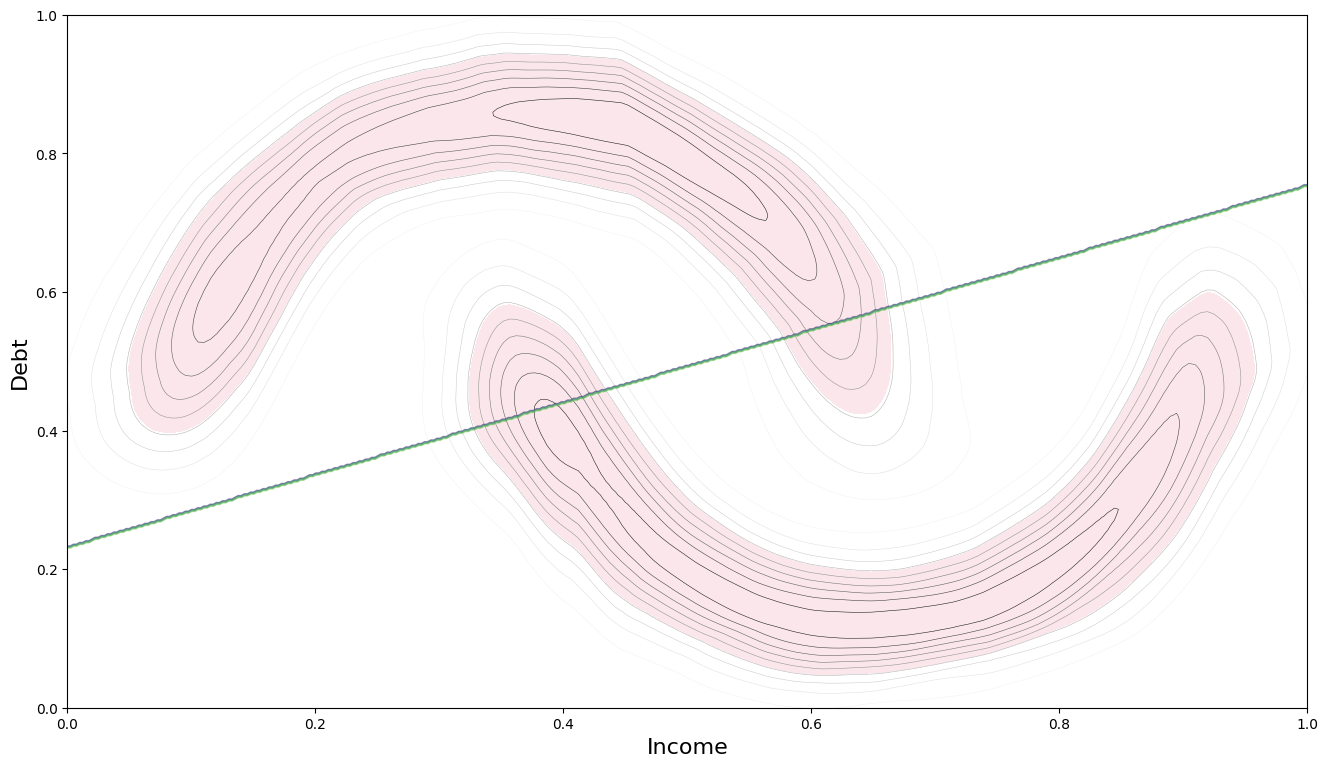

In [35]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_generative_model_distribution(ax, flow, 1.2, 2)
plot_classifier_decision_region(ax, disc_model)
# increase phont size
ax.set_xlabel("Income", fontsize=16)
ax.set_ylabel("Debt", fontsize=16)
# save as pdf
plt.savefig("example.pdf", bbox_inches="tight")

/Users/ofurman/Private/counterfactuals/venv/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


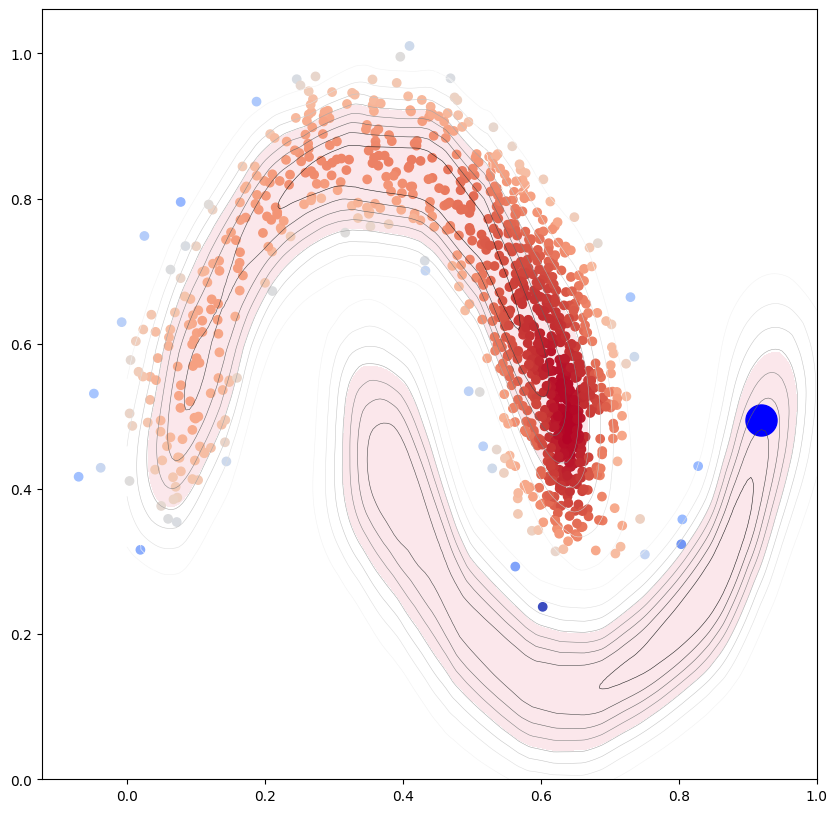

In [19]:
i = 3
with torch.no_grad():
    points, log_prob = cf.sample_and_log_prob(
        1000, context=torch.from_numpy(np.array([class_one[i]]))
    )

points = points.squeeze().numpy()
# plot points with colorized log prob
# fig, ax = plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(figsize=(10, 10))
plot_generative_model_distribution(ax, flow, 1.2, 2)
ax.scatter(class_one[i, 0], class_one[i, 1], c="blue", s=500)
ax.scatter(points[:, 0], points[:, 1], c=log_prob, cmap=cm.coolwarm)

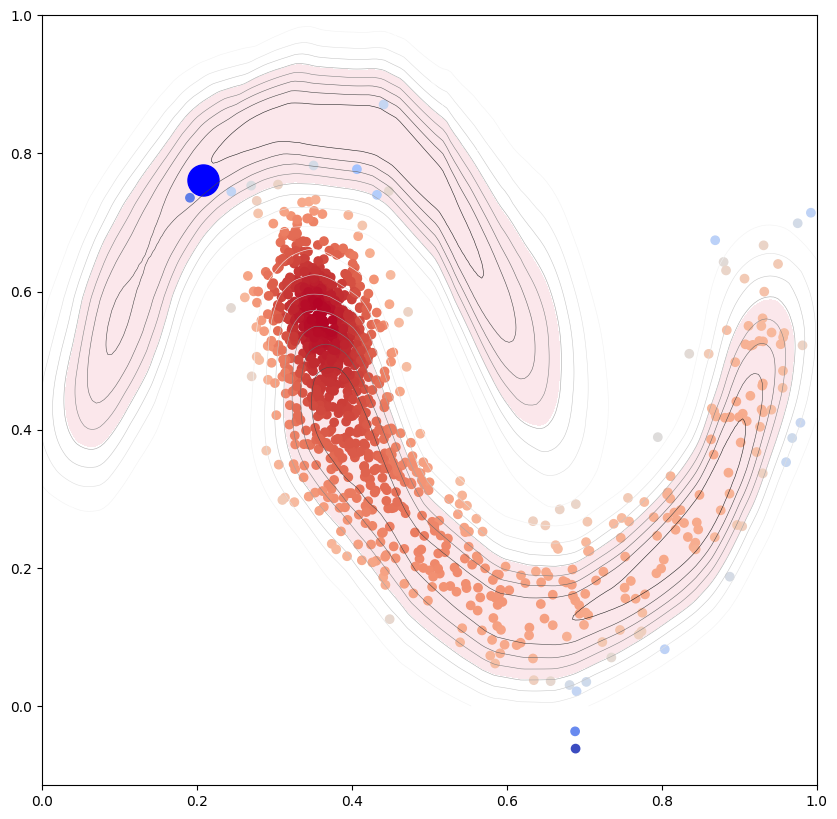

In [20]:
i = 1
with torch.no_grad():
    points, log_prob = cf.sample_and_log_prob(
        1000, context=torch.from_numpy(np.array([class_zero[i]]))
    )

points = points.squeeze().numpy()
# plot points with colorized log prob
fig, ax = plt.subplots(figsize=(10, 10))
plot_generative_model_distribution(ax, flow, 1.2, 2)
ax.scatter(class_zero[i, 0], class_zero[i, 1], c="blue", s=500)
ax.scatter(points[:, 0], points[:, 1], c=log_prob, cmap=cm.coolwarm)